In [1]:
import kipoi
import sys
sys.path.insert(0,'/srv/scratch/manyu/software/modisco_private/modisco/visualization/')
import viz_sequence
import tensorflow
from keras.layers import Conv1D
import os
import tensorflow as tf
import keras.backend as K
DEFER_DELETE_SIZE=int(250 * 1e6)
def create_tensorflow_session(visiblegpus):
    os.environ['CUDA_VISIBLE_DEVICES'] = str(visiblegpus)
    session_config = tf.ConfigProto()
    session_config.gpu_options.deferred_deletion_bytes = DEFER_DELETE_SIZE
    session_config.gpu_options.per_process_gpu_memory_fraction = 0.45
    session = tf.Session(config=session_config)
    K.set_session(session)
    return session


/users/manyu/anaconda3/envs/kipoi_model_loader/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sess=create_tensorflow_session(0)

In [ ]:
kipoi_model_ctcf=kipoi.get_model('DeepBind/D00328.018')

In [ ]:
model_ctcf=kipoi_model_ctcf.model

In [ ]:
model_ctcf_conv_layer=model_ctcf.get_layer('conv1d_850').get_weights()

In [ ]:
filters_ctcf,biases_ctcf=model_ctcf_conv_layer[0],model_ctcf_conv_layer[1]
filters_ctcf.shape,biases_ctcf.shape

In [ ]:
lambda_2326=model_ctcf.get_layer('lambda_2326').get_weights()

In [ ]:
lambda_2327=model_ctcf.get_layer('lambda_2327').get_weights()

In [ ]:
###What do these 2 layers do anyway

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


In [ ]:
SVG(model_to_dot(model_ctcf).create(prog='dot', format='svg'))



In [ ]:
path_to_trained_deepbind_model_arch='/mnt/lab_data/kundaje/manyu/kipoi_models/deepbind_CEBPB_HeLa-S3_val20/model.arch.json'
path_to_trained_deepbind_model_weights='/mnt/lab_data/kundaje/manyu/kipoi_models/deepbind_CEBPB_HeLa-S3_val20/model.weights.h5'

In [ ]:
from keras.models import model_from_json



In [ ]:
with open(path_to_trained_deepbind_model_arch,'r') as f:
    model_cebpb_deepbind_trained=model_from_json(f.read())

In [ ]:
model_cebpb_deepbind_trained.load_weights(path_to_trained_deepbind_model_weights)

In [ ]:
SVG(model_to_dot(model=model_cebpb_deepbind_trained).create(prog='dot', format='svg'))

In [ ]:
######Analysis for the ctcf conv filter motifs continue


In [ ]:
filters_ctcf.shape,biases_ctcf.shape

In [ ]:
filters_ctcf=filters_ctcf.transpose((2,1,0))
print(filters_ctcf.shape)

In [ ]:
for i in range(len(filters_ctcf)):
    viz_sequence.plot_weights(filters_ctcf[i])

In [ ]:
###Deepbind filters for this CTCF chipseq certainly pick out the CTCF motif.
###We now need to see what happens on using these to filter out sequences and averaging them 
###To get the appropriate frequency statistics

In [ ]:
model_cebpb_trained_conv_layer=model_cebpb_deepbind_trained.get_layer('convolution1d_1').get_weights()

In [ ]:
filters_cebpb_trained,biases_cebpb_trained = model_cebpb_trained_conv_layer[0],model_cebpb_trained_conv_layer[1]

In [ ]:
filters_cebpb_trained=filters_cebpb_trained.transpose((2,1,0))

In [ ]:
for i in range(len(filters_cebpb_trained)):
    viz_sequence.plot_weights(filters_cebpb_trained[i])

In [ ]:
biases_cebpb_trained

In [3]:
##DeepBind model D00317.009 (CEBPB HeLAS3)
kipoi_model_cebpb_DeepBind=kipoi.get_model('DeepBind/D00317.009')

In [4]:
model_cebpb = kipoi_model_cebpb_DeepBind.model

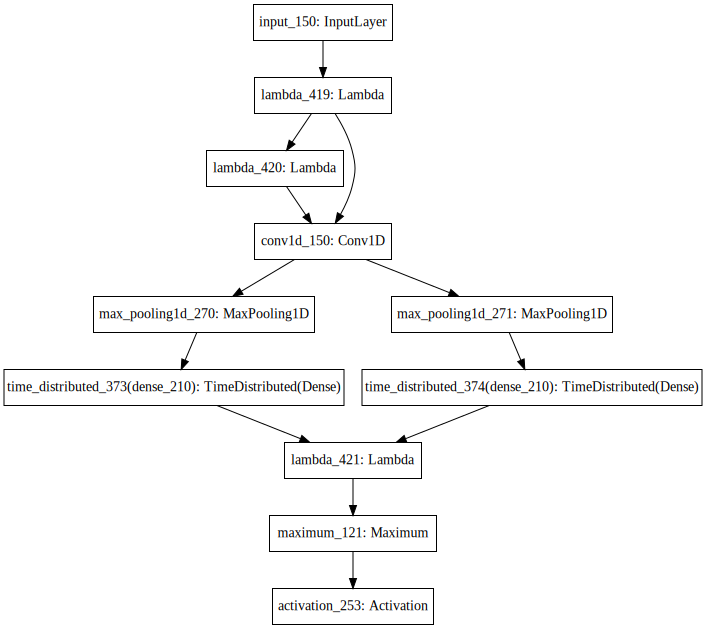

In [6]:
SVG(model_to_dot(model_cebpb).create(prog='dot', format='svg'))



In [7]:
conv_layer_cebpb_deepbind=model_cebpb.get_layer('conv1d_150').get_weights()

In [8]:
filters_cebpb_deepbind,biases_cebpb_deepbind = conv_layer_cebpb_deepbind[0],conv_layer_cebpb_deepbind[1]

In [9]:
filters_cebpb_deepbind.shape,biases_cebpb_deepbind.shape



((24, 4, 16), (16,))

In [10]:
filters_cebpb_deepbind_viz=filters_cebpb_deepbind.transpose((2,1,0))

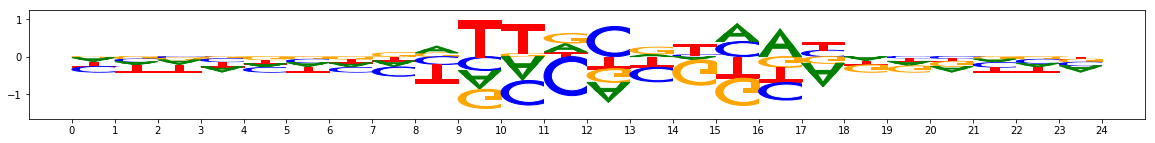

In [11]:
viz_sequence.plot_weights(filters_cebpb_deepbind_viz[4])

In [12]:
biases_cebpb_deepbind

array([-0.6908197 , -1.2650334 , -1.2401764 , -0.6464666 , -1.6901276 ,
       -0.93994117, -0.7390936 , -0.3986189 , -0.6980144 , -0.51405853,
       -0.7158519 , -1.2699357 , -1.4095954 , -0.4744839 , -0.63738817,
       -1.4345058 ], dtype=float32)

In [13]:
###The filters look much much clearer for the DeepBind models surprisngly

In [14]:
###Get test set positive intervals

In [14]:
path_to_test_intervals_CEBPB_HeLAS3='/srv/scratch/manyu/kipoi/manuscript_code/experiments/tfbinding/interval_files/chr8_wide_bin101_flank0_stride101.CEBPB.HeLa-S3.intervals_file.tsv.gz'

In [15]:
import numpy as np
import gzip

In [ ]:
test_intervals=np.loadtxt(path_to_test_intervals_CEBPB_HeLAS3,dtype=str)

In [ ]:
labels=test_intervals[:,-1].astype(np.int)

In [ ]:
positive_locations=np.where(labels==1)[0]

In [ ]:
positive_intervals=test_intervals[positive_locations]

In [15]:
from  pybedtools.bedtool import BedTool
from genomelake.extractors import ArrayExtractor

In [ ]:
np.savetxt(X=positive_intervals,fname='./intervals_to_evaluate/CEBPB_HeLAS3_chr8.bed',fmt='%s',delimiter='\t')

In [16]:
intervals_bedtool=BedTool('./intervals_to_evaluate/CEBPB_HeLAS3_chr8.bed')

In [17]:
hg19_extractor=ArrayExtractor('/srv/scratch/genomelake_data/hg19.genome.fa/')

In [18]:
interval_0 = hg19_extractor([intervals_bedtool[0]])

In [32]:
small_interval_set=[intervals_bedtool[i] for i in range(10)]
small_intervals = hg19_extractor(small_interval_set)



In [23]:
import numpy as np

In [24]:
filters_cebpb_deepbind.shape

(24, 4, 16)

In [25]:
filters_cebpb_deepbind_reshape=np.expand_dims(filters_cebpb_deepbind.transpose(1,0,2),axis=2)
assert filters_cebpb_deepbind_reshape.shape==(4,24,1,16)

In [26]:
interval_0_reshape=np.expand_dims(interval_0.transpose(2,1,0),axis=0)
assert interval_0_reshape.shape==(1,4,101,1)

In [27]:
interval=tf.placeholder(shape=(None,4,101,1),dtype=tf.float32)


In [28]:
kernel=tf.placeholder(shape=(4,24,1,16),dtype=tf.float32)

In [29]:
conv_operation = tf.nn.conv2d(input=interval,filter=kernel,strides=[1,1,1,1],padding='VALID')


In [30]:
scored_interval=sess.run(conv_operation,feed_dict={interval:interval_0_reshape,kernel:filters_cebpb_deepbind_reshape})

In [31]:
scored_interval=np.squeeze(scored_interval)

In [72]:
scored_interval[:,1]+biases_cebpb_deepbind[1]

array([-4.016366 , -2.44841  , -0.7744927, -2.4104438, -3.9131026,
       -1.8912716, -3.8496156, -3.6758814, -3.8017325, -3.7477155,
       -2.5887742, -2.8225179, -3.1822696, -4.0255733, -4.415773 ,
       -4.27314  , -3.4412713, -3.588861 , -2.8512328, -2.746579 ,
       -1.0857186, -4.734732 , -3.867814 , -2.1743336, -4.5399613,
       -3.316186 , -3.8733263, -1.820386 , -1.8617744, -4.809892 ,
       -2.577252 , -3.3772044, -1.6648803, -5.28029  , -2.043486 ,
       -2.9164414, -2.4475758, -4.5519333, -2.6708658, -3.4778223,
       -2.8012855, -2.633842 , -2.9378064, -3.6542392, -2.344687 ,
       -3.9936275, -3.1466823, -2.5126777, -3.0834436, -4.5507464,
       -2.1080918, -2.22001  , -2.7679782, -2.7910604, -3.5855246,
       -4.2337594, -3.7919974, -3.6890574, -2.2759771, -3.2949996,
       -2.6649904, -3.2321448, -3.6392312, -3.341713 , -2.3532262,
       -3.341045 , -3.6508002, -4.7125254, -4.28302  , -4.2789574,
       -2.3815134, -1.3488088, -4.2963176, -1.6712477, -2.7985

In [82]:
thresholded_scores=scored_interval+biases_cebpb_deepbind

In [88]:
x=tf.placeholder(shape=(None,None),dtype=tf.float32)
thresholded_scores_relu=sess.run(tf.nn.relu(x),{x:thresholded_scores})

In [145]:
np.where(thresholded_scores_relu[:,10]>0)

(array([33, 70]),)

In [159]:
i=6
print(thresholded_scores_relu[:,i],biases_cebpb_deepbind[i])
max_val=np.argmax(thresholded_scores_relu[:,i])

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.5192403 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06755424, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.    

In [160]:
high=interval_0[:,max_val:max_val+24,:]
high=np.squeeze(high)

In [86]:
def OneHot_to_string(arr):
    mapping={(1,0,0,0):'a',(0,1,0,0):'c',(0,0,1,0):'g',(0,0,0,1):'t'}
    string=''
    for i in range(len(arr)):
        string+=mapping[tuple(arr[i])]
    return(string)    
        

In [161]:
OneHot_to_string(high)

'gcagcatgactcactccagatata'

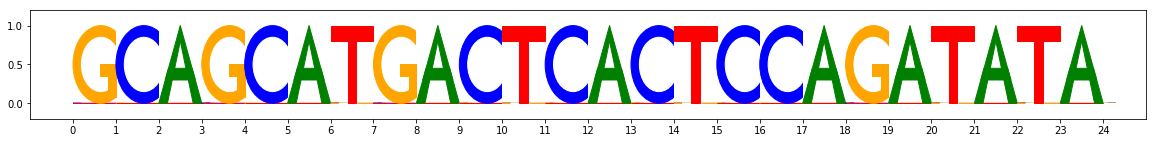

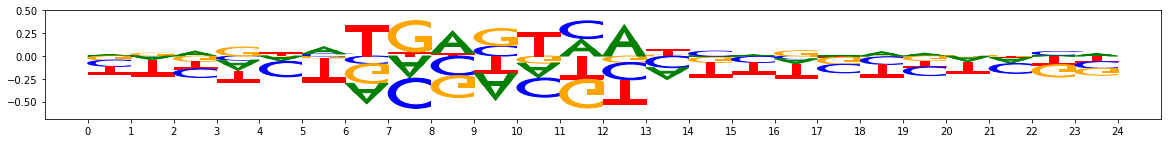

In [162]:
viz_sequence.plot_weights(high)
viz_sequence.plot_weights(filters_cebpb_deepbind_viz[6])

In [35]:
small_intervals.shape
small_interval_reshape=np.expand_dims(small_intervals.transpose(2,1,0),axis=-1)
assert interval_0_reshape.shape==(10,4,101,1)

AssertionError: 

In [36]:
small_intervals.shape

(10, 101, 4)

In [38]:
small_interval_reshape=np.expand_dims(small_intervals.transpose(0,2,1),axis=-1)
assert small_interval_reshape.shape==(10,4,101,1)

In [55]:
conv_operation = tf.nn.conv2d(input=interval,filter=kernel,strides=[1,1,1,1],padding='VALID')


In [56]:
biases=tf.placeholder(shape=(16,),dtype=tf.float32)

In [57]:
activated_locations=tf.nn.relu(conv_operation+biases)

In [58]:
feed_dict = {interval:small_interval_reshape,kernel:filters_cebpb_deepbind_reshape,biases:biases_cebpb_deepbind}

In [59]:
small_interval_activated_scores=sess.run(activated_locations,feed_dict=feed_dict)

In [65]:
small_interval_activated_scores.shape

(10, 1, 78, 16)

In [218]:
small_interval_activated_scores[8,:,:,4]

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 1.3093135, 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ]],
      dtype=float32)

In [219]:
position=np.argmax(small_interval_activated_scores[8,:,:,4])
print(position)


68


(10, 101, 4)


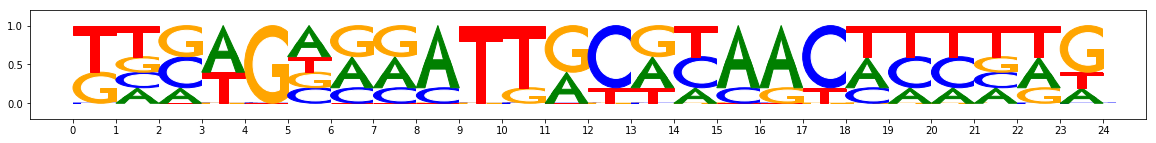

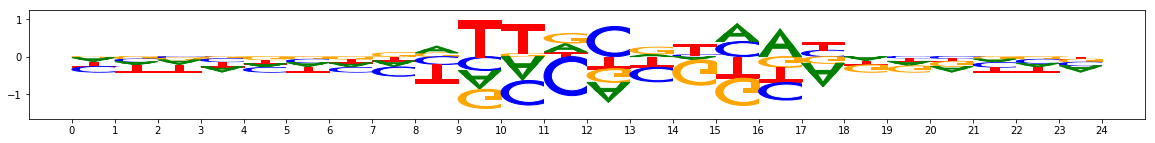

In [345]:
print(small_intervals.shape)
val=np.zeros((24,4))
val[:]+=small_intervals[8,68:68+24,:]+small_intervals[6,63:63+24,:]+small_intervals[4,24:24+24,:]+small_intervals[2,47:47+24,:]+small_intervals[0,75:75+24,:]
viz_sequence.plot_weights(val/5.0)
viz_sequence.plot_weights(filters_cebpb_deepbind.transpose((2,1,0))[4])

In [171]:
def pwm(pfm):
    pwm = np.log(pfm/.25)/np.log(2)
    return pwm

def pfm_with_pseudocount(pfm,pseudocount=.001):
    pfm+=pseudocount
    pfm/=(1.0+4*pseudocount)
    return pfm

In [179]:
pfm_normalized=pfm_with_pseudocount(pfm)
def get_information_content_matrix(pfm):
    return pfm*np.log2(pfm/0.25)

In [329]:
pfm_info=get_information_content_matrix(pfm_with_pseudocount(val/5.0))

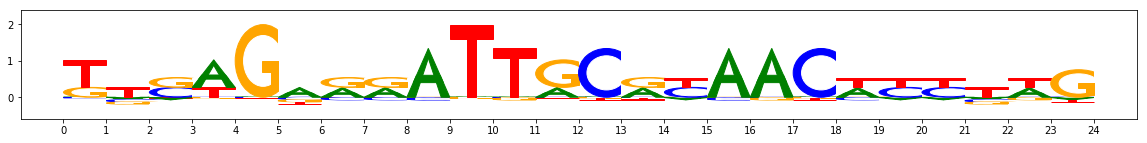

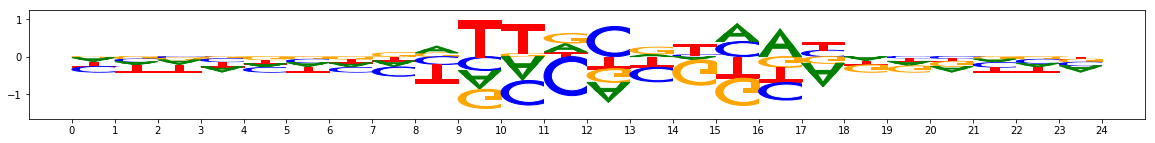

In [330]:
viz_sequence.plot_weights(pfm_info)
viz_sequence.plot_weights(filters_cebpb_deepbind.transpose((2,1,0))[4])

In [208]:
def activated_locations_with_filters(intervals,filters,biases):
    #Calculates the locations that activate the relu after colvolution and bias
    
    #intervals shape = (batch_size,height,width,num_channels) ex. (None,4,101,1)   
    #filters shape = (height,width,input_channels,out_channels) ex . (4,24,1,16)
    #biases shape = (out_channels,)  ex.(16,)
    assert len(intervals.shape) == 4
    assert len(filters.shape) == 4
    assert intervals.shape[1] == filters.shape[0]   #Heights match
    assert intervals.shape[-1] == 1  #Number of input channels = 1
    assert filters.shape[2] == 1    #Number of input channels = 1
    assert len(biases.shape) == 1
    assert biases.shape[0] == filters.shape[-1] 
    print("All shapes are compatible:")
    print("Proceeding with convolutions:")
    total_bases = filters.shape[0]
    total_filters = biases.shape[0]
    total_intervals = intervals.shape[0]
    filter_width = filters.shape[1]
    interval_width = intervals.shape[2]
    
    ##Define placeholder variables
    intervals_placeholder = tf.placeholder(shape=intervals.shape,dtype=tf.float32)
    filters_placeholder = tf.placeholder(shape=filters.shape,dtype=tf.float32)
    biases_placeholder = tf.placeholder(shape=biases.shape,dtype=tf.float32)
    ##Feed Dict
    feed_dict={intervals_placeholder:intervals,filters_placeholder:filters,biases_placeholder:biases}
    ##Convolution Op
    convolution_op = tf.nn.conv2d(input=intervals_placeholder,filter=filters_placeholder,strides=[1,1,1,1],padding='VALID')
    activated_locations_op = tf.nn.relu(convolution_op+biases_placeholder)
    activated_locations = sess.run(activated_locations_op,feed_dict=feed_dict)
    return activated_locations,total_bases,total_filters,total_intervals,filter_width,interval_width

    
    

In [196]:
biases_cebpb_deepbind.shape

(16,)

In [203]:
convolution_with_filters(small_interval_reshape,filters_cebpb_deepbind_reshape,biases_cebpb_deepbind)

All shapes are compatible:
Proceeding with convolutions:
4 16


In [209]:
locations,b_,f_,i_,f_w_,i_w_=activated_locations_with_filters(small_interval_reshape,filters_cebpb_deepbind_reshape,biases_cebpb_deepbind)

All shapes are compatible:
Proceeding with convolutions:


In [217]:
b_,f_,i_,f_w_,i_w_

(4, 16, 10, 24, 101)

In [243]:
np.sum(small_interval_reshape[4,:,24:24+24,:].squeeze()*filters_cebpb_deepbind_reshape[:,:,:,4].squeeze())+biases_cebpb_deepbind[4]

1.6546953

In [408]:
def get_motifs_from_activations(activations,intervals,filters,biases):
    ##activations shape= (10,1,78,16)
    
    #intervals shape = (batch_size,height,width,num_channels) ex. (10,4,101,1)   
    #filters shape = (height,width,input_channels,out_channels) ex . (4,24,1,16)
    #biases shape = (out_channels,)  ex.(16,)
    intervals = intervals.squeeze()
    activations = activations.squeeze()
    total_sequences_in_batch = len(activations)
    assert filters.shape[-1] == biases.shape[0]    #This is the total filters
    total_filters = biases.shape[0]
    filter_width = filters.shape[1]
    total_bases=filters.shape[0]
    pfm_arr_list=[]
    for i in range(total_filters):
        ##Find all seqeunces that activate this specific filter
        total_activated_sequences=0
        sum_activating_sequences=np.zeros((total_bases,filter_width))
        print("Doing filter %s"%(str(i)))
        for j in range(total_sequences_in_batch):
            if np.max(activations[j,:,i])>0.0:
                max_location_in_sequence = np.argmax(activations[j,:,i])
                #print("max_location in sequence%s is %s"%(j,max_location_in_sequence))
                
                max_sequence = intervals[j,:,max_location_in_sequence:max_location_in_sequence+filter_width]
                #print(max_sequence.shape)
                assert max_sequence.shape==sum_activating_sequences.shape
                sum_activating_sequences[:,:] += max_sequence
                total_activated_sequences +=1
        
        #sum_activating_sequences/=total_activated_sequences
        pfm_arr_list.append((sum_activating_sequences,total_activated_sequences))
        
    return pfm_arr_list

                
            
            
            
            
            
        
        
        
    

In [283]:
locations,b_,f_,i_,f_w_,i_w_=activated_locations_with_filters(small_interval_reshape,filters_cebpb_deepbind_reshape,biases_cebpb_deepbind)

All shapes are compatible:
Proceeding with convolutions:


In [279]:
locations.shape,small_interval_reshape.shape,filters_cebpb_deepbind_reshape.shape,biases_cebpb_deepbind.shape

((10, 1, 78, 16), (10, 4, 101, 1), (4, 24, 1, 16), (16,))

In [409]:
%reload_ext autoreload
%autoreload 2
from pwm_utils import get_motifs_from_activations
pfm_list=get_motifs_from_activations(activations=locations,intervals=small_interval_reshape,filters=filters_cebpb_deepbind_reshape,biases=biases_cebpb_deepbind)

Doing filter 0
Doing filter 1
Doing filter 2
Doing filter 3
Doing filter 4
Doing filter 5
Doing filter 6
Doing filter 7
Doing filter 8
Doing filter 9
Doing filter 10
Doing filter 11
Doing filter 12
Doing filter 13
Doing filter 14
Doing filter 15


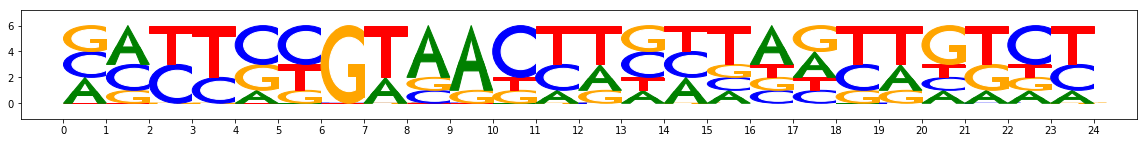

In [410]:
viz_sequence.plot_weights(pfm_list[0][0])

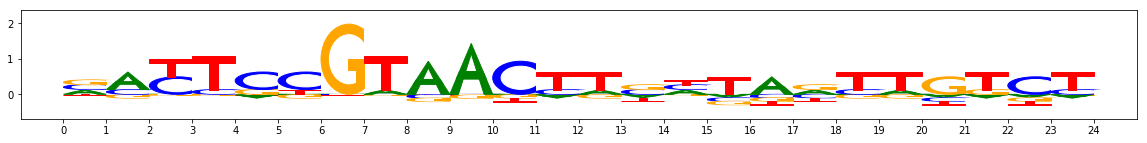

In [300]:
viz_sequence.plot_weights(get_information_content_matrix(pfm_with_pseudocount(pfm_list[0][0]/6.0)))

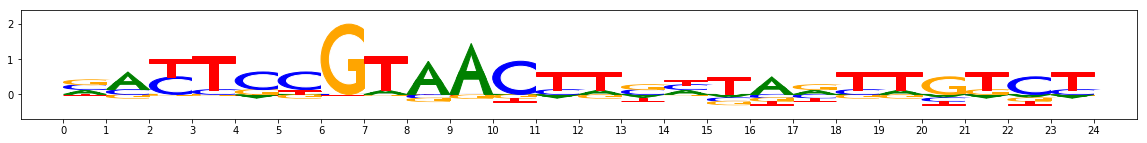

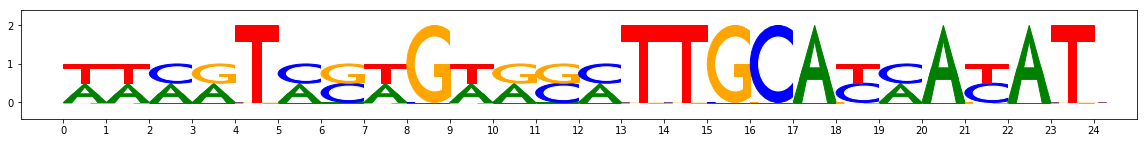

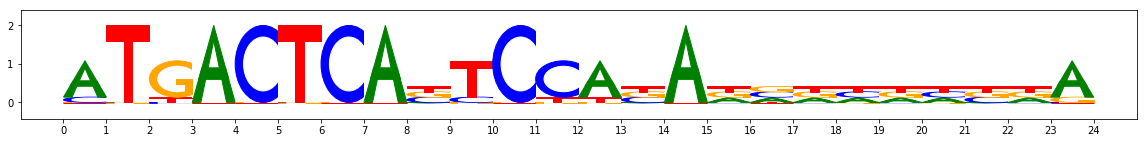

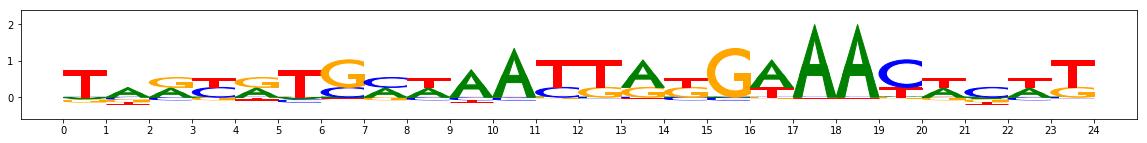

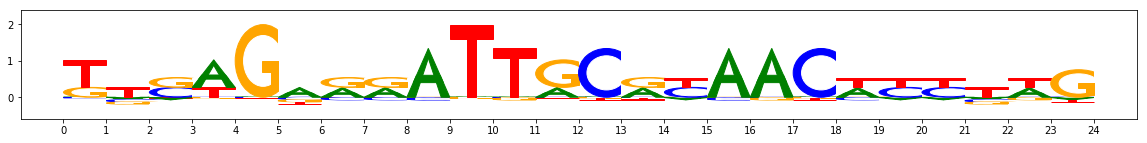

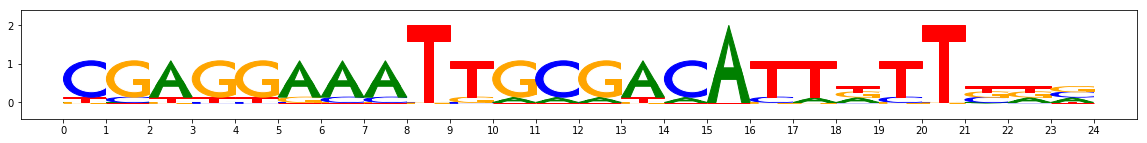

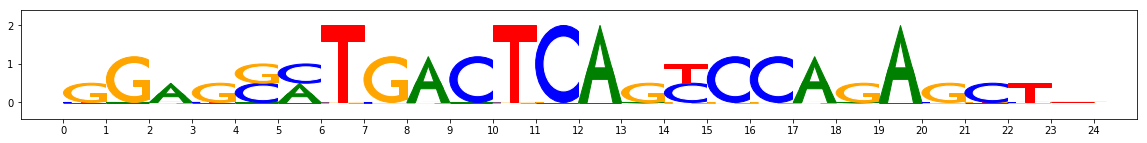

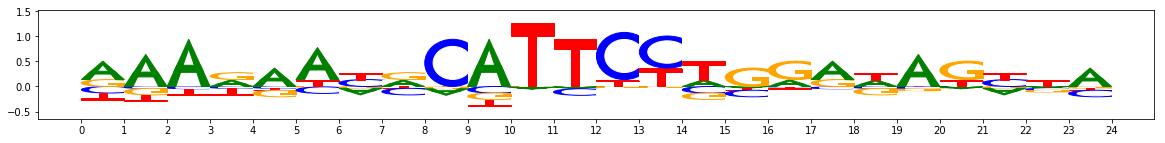

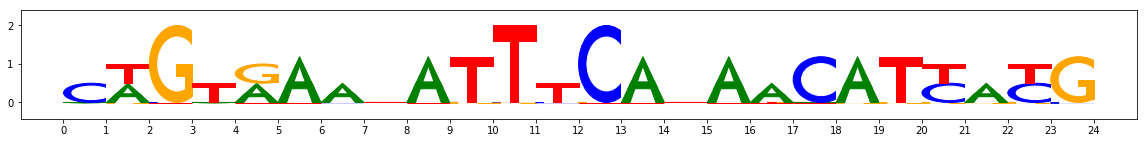

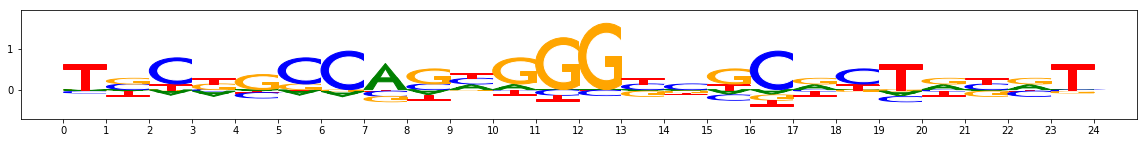

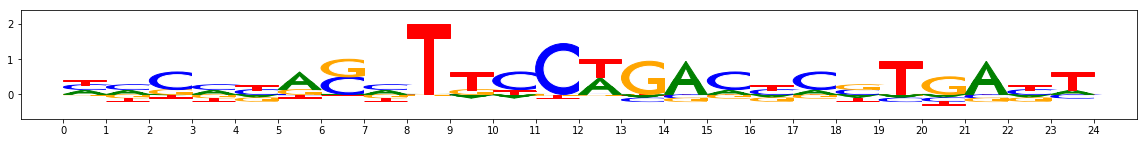

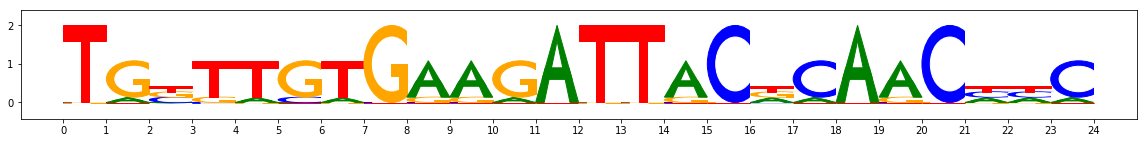

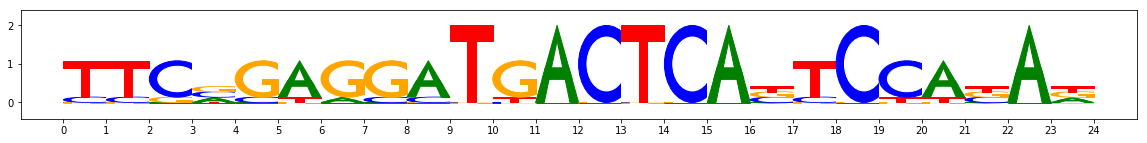

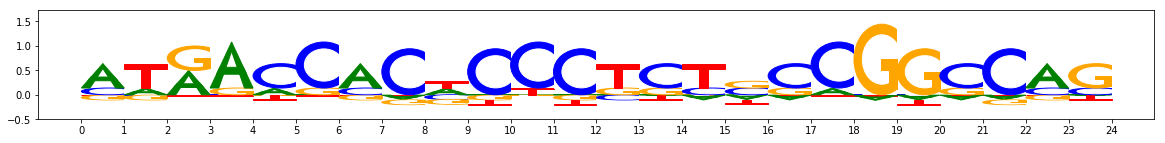

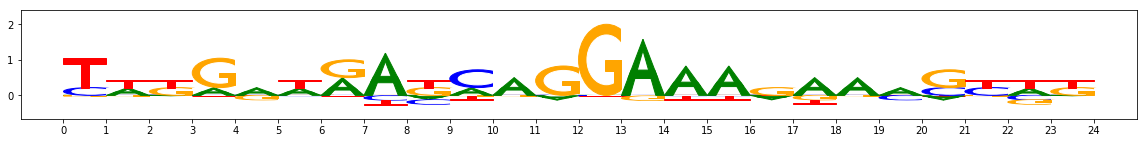

In [411]:
for elem in pfm_list:
    pfm,counts = elem[0],elem[1]
    if counts>0:
        pfm/=(counts+0.0)
        viz_sequence.plot_weights(get_information_content_matrix(pfm_with_pseudocount(pfm)))

In [317]:
np.array_equal(get_information_content_matrix(pfm_with_pseudocount(pfm_list[4][0])),pfm_info.transpose())

False

In [318]:
get_information_content_matrix(pfm_with_pseudocount(pfm_list[4][0]))

array([[-0.03569652, -0.06283452, -0.06283452,  0.73183616, -0.03569652,
         0.26249328,  0.26249328,  0.26249328,  1.29536599, -0.03569652,
        -0.03569652,  0.26249328, -0.03569652,  0.26249328, -0.06283452,
         1.29536599,  1.29536599, -0.03569652,  0.26249328, -0.06283452,
        -0.06283452, -0.06283452,  0.26249328, -0.06283452],
       [-0.03569652, -0.06283452,  0.26249328, -0.03569652, -0.03569652,
        -0.06283452, -0.06283452, -0.06283452, -0.06283452, -0.03569652,
        -0.03569652, -0.03569652,  1.29536599, -0.03569652,  0.26249328,
        -0.06283452, -0.03569652,  1.29536599, -0.06283452,  0.26249328,
         0.26249328, -0.06283452, -0.03569652, -0.03569652],
       [ 0.26249328, -0.06283452,  0.26249328, -0.03569652,  1.92915669,
        -0.06283452,  0.26249328,  0.26249328, -0.03569652, -0.03569652,
        -0.06283452,  0.73183616, -0.03569652,  0.26249328, -0.03569652,
        -0.03569652, -0.06283452, -0.03569652, -0.03569652, -0.03569652,
  

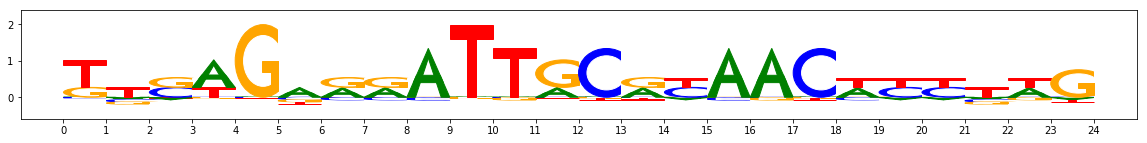

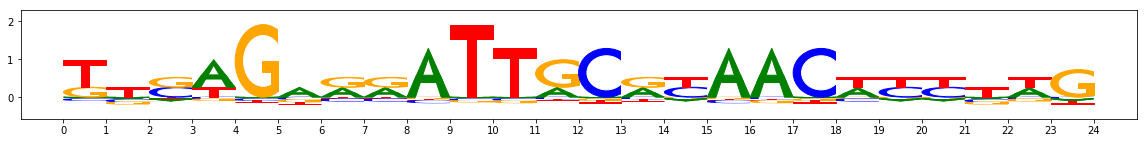

In [331]:
viz_sequence.plot_weights(pfm_info.transpose())
viz_sequence.plot_weights(get_information_content_matrix(pfm_with_pseudocount(pfm_list[4][0])))

In [339]:
np.array_equal(pfm_info.transpose(),get_information_content_matrix(pfm_with_pseudocount(pfm_list[4][0])))

False

In [342]:
pfm_info

array([[-0.00793978, -0.00793978,  0.26996202,  0.75405005],
       [-0.06416222, -0.06416222, -0.06416222,  0.26996202],
       [-0.06416222,  0.26996202,  0.26996202, -0.00793978],
       [ 0.75405005, -0.00793978, -0.00793978,  0.26996202],
       [-0.00793978, -0.00793978,  1.98971951, -0.00793978],
       [ 0.26996202, -0.06416222, -0.06416222, -0.06416222],
       [ 0.26996202, -0.06416222,  0.26996202, -0.00793978],
       [ 0.26996202, -0.06416222,  0.26996202, -0.00793978],
       [ 1.33562352, -0.06416222, -0.00793978, -0.00793978],
       [-0.00793978, -0.00793978, -0.00793978,  1.98971951],
       [-0.00793978, -0.00793978, -0.06416222,  1.33562352],
       [ 0.26996202, -0.00793978,  0.75405005, -0.00793978],
       [-0.00793978,  1.33562352, -0.00793978, -0.06416222],
       [ 0.26996202, -0.00793978,  0.26996202, -0.06416222],
       [-0.06416222,  0.26996202, -0.00793978,  0.26996202],
       [ 1.33562352, -0.06416222, -0.00793978, -0.00793978],
       [ 1.33562352, -0.

In [343]:
get_information_content_matrix(pfm_with_pseudocount(pfm_list[4][0])).transpose()

array([[-0.06446259, -0.06446259,  0.25053248,  0.69632725],
       [-0.06067018, -0.06067018, -0.06067018,  0.25053248],
       [-0.06067018,  0.25053248,  0.25053248, -0.06446259],
       [ 0.69632725, -0.06446259, -0.06446259,  0.25053248],
       [-0.06446259, -0.06446259,  1.83236255, -0.06446259],
       [ 0.25053248, -0.06067018, -0.06067018, -0.06067018],
       [ 0.25053248, -0.06067018,  0.25053248, -0.06446259],
       [ 0.25053248, -0.06067018,  0.25053248, -0.06446259],
       [ 1.23103059, -0.06067018, -0.06446259, -0.06446259],
       [-0.06446259, -0.06446259, -0.06446259,  1.83236255],
       [-0.06446259, -0.06446259, -0.06067018,  1.23103059],
       [ 0.25053248, -0.06446259,  0.69632725, -0.06446259],
       [-0.06446259,  1.23103059, -0.06446259, -0.06067018],
       [ 0.25053248, -0.06446259,  0.25053248, -0.06067018],
       [-0.06067018,  0.25053248, -0.06446259,  0.25053248],
       [ 1.23103059, -0.06067018, -0.06446259, -0.06446259],
       [ 1.23103059, -0.

In [346]:
print(small_intervals.shape)
val=np.zeros((24,4))
val[:]+=small_intervals[8,68:68+24,:]+small_intervals[6,63:63+24,:]+small_intervals[4,24:24+24,:]+small_intervals[2,47:47+24,:]+small_intervals[0,75:75+24,:]


(10, 101, 4)


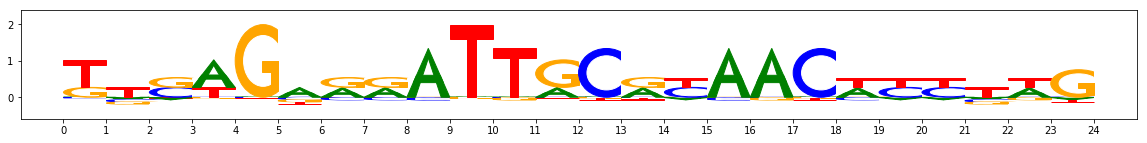

In [357]:
viz_sequence.plot_weights(get_information_content_matrix(pfm_with_pseudocount(val/5.0)))

In [412]:
large_interval_set=[intervals_bedtool[i] for i in range(1000)]
large_intervals = hg19_extractor(large_interval_set)



ValueError: could not broadcast input array from shape (10,4) into shape (101,4)

In [414]:
intervals_300=intervals_bedtool[300]

In [416]:
for count,interval_ in enumerate(intervals_bedtool):
    if interval_.length!=101:
        print count
        break

308


In [362]:
large_intervals_reshape=np.expand_dims(large_intervals.transpose((0,2,1)),axis=-1)
print(large_intervals_reshape.shape)

(100, 4, 101, 1)


In [363]:
locations_large,b_,f_,i_,f_w_,i_w_=activated_locations_with_filters(large_intervals_reshape,filters_cebpb_deepbind_reshape,biases_cebpb_deepbind)

All shapes are compatible:
Proceeding with convolutions:


In [366]:
pfm_list_large=get_motifs_from_activations(activations=locations_large,intervals=large_intervals_reshape,filters=filters_cebpb_deepbind_reshape,biases=biases_cebpb_deepbind)

Doing filter 0
max_location in sequence4 is 6
max_location in sequence5 is 57
max_location in sequence6 is 17
max_location in sequence7 is 77
max_location in sequence8 is 75
max_location in sequence9 is 54
max_location in sequence12 is 61
max_location in sequence13 is 39
max_location in sequence15 is 67
max_location in sequence16 is 71
max_location in sequence19 is 5
max_location in sequence22 is 63
max_location in sequence23 is 27
max_location in sequence24 is 67
max_location in sequence25 is 53
max_location in sequence26 is 69
max_location in sequence27 is 36
max_location in sequence28 is 33
max_location in sequence29 is 8
max_location in sequence30 is 69
max_location in sequence31 is 13
max_location in sequence33 is 24
max_location in sequence35 is 3
max_location in sequence36 is 57
max_location in sequence38 is 76
max_location in sequence39 is 72
max_location in sequence40 is 28
max_location in sequence42 is 11
max_location in sequence43 is 5
max_location in sequence44 is 65
max_lo

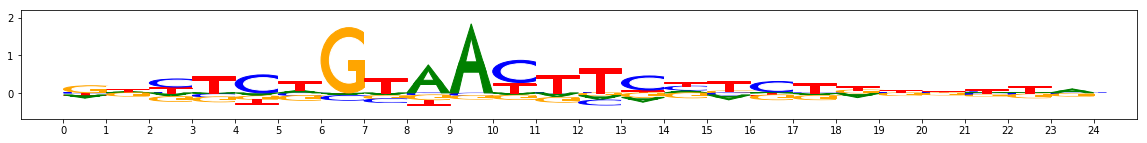

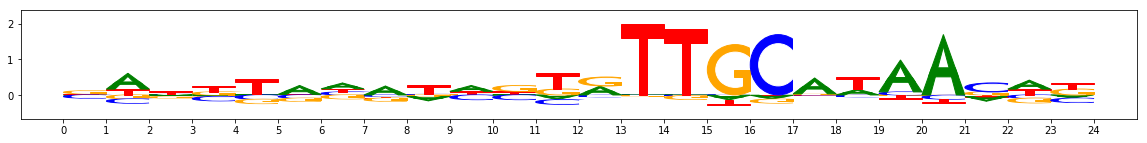

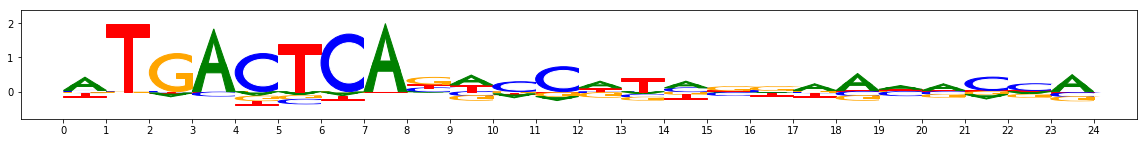

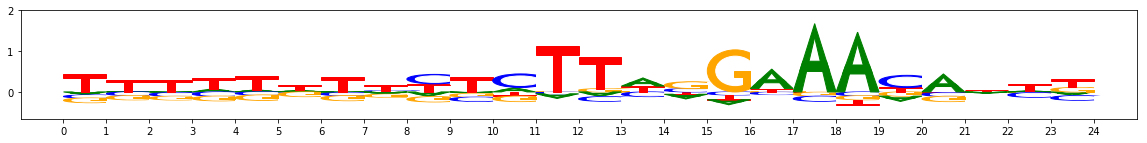

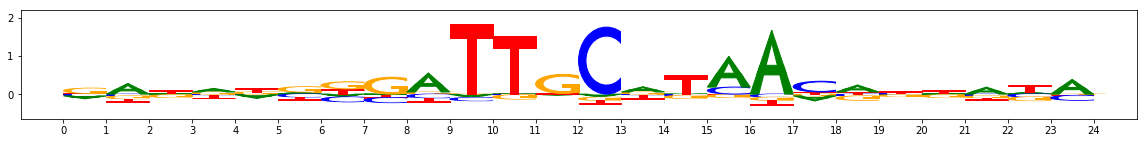

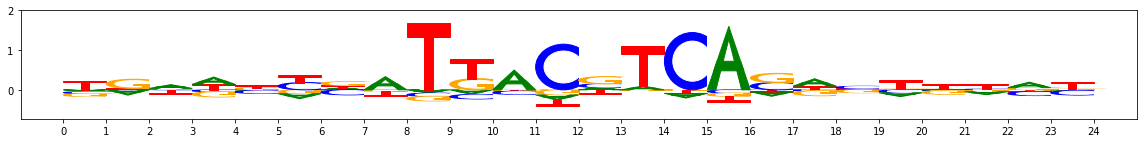

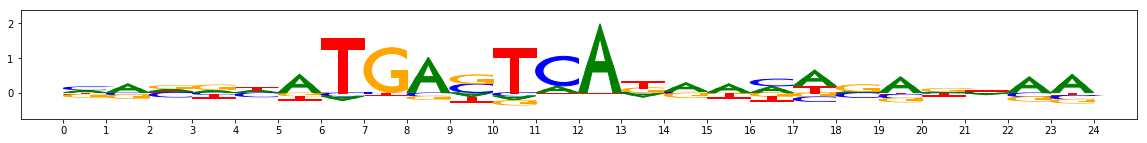

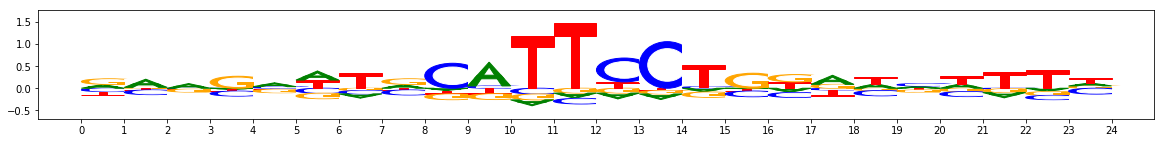

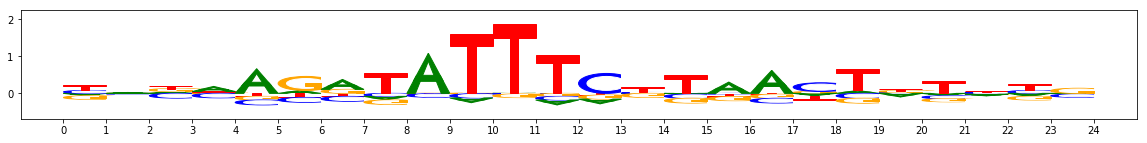

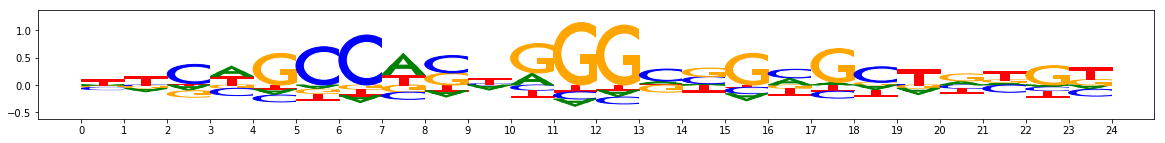

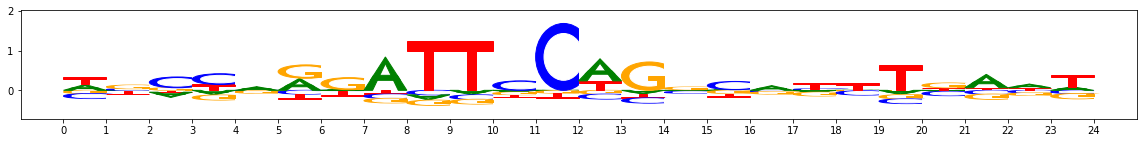

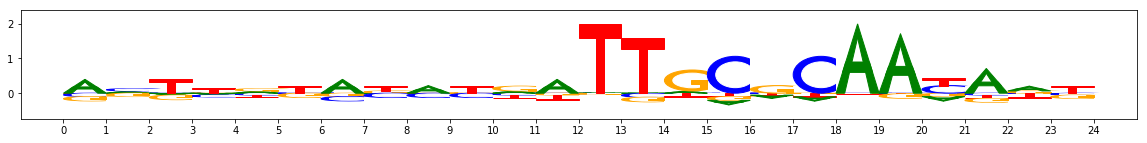

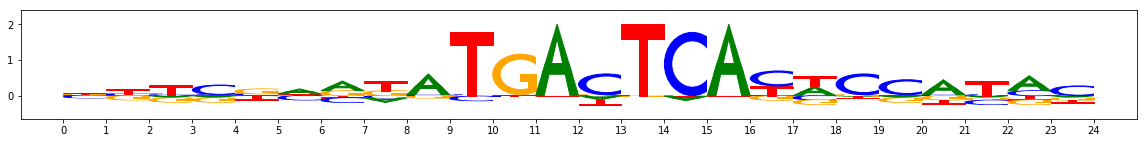

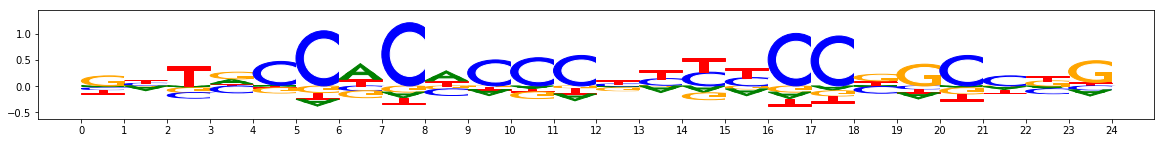

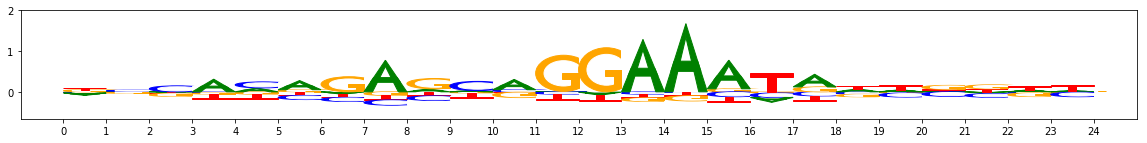

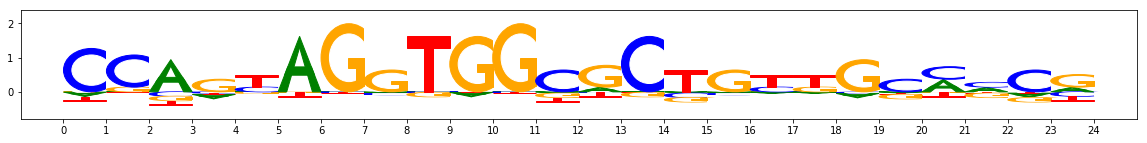

In [367]:
for elem in pfm_list_large:
    pfm,counts = elem[0],elem[1]
    if counts>0:
        pfm/=(counts+0.0)
        viz_sequence.plot_weights(get_information_content_matrix(pfm_with_pseudocount(pfm)))

In [377]:
from pwm_utils import get_counts_list

In [378]:
counts_list=get_counts_list(small_interval_reshape,filters_cebpb_deepbind_reshape,biases_cebpb_deepbind)

All shapes are compatible:
Proceeding with convolutions:
Doing filter 0
max_location in sequence4 is 6
max_location in sequence5 is 57
max_location in sequence6 is 17
max_location in sequence7 is 77
max_location in sequence8 is 75
max_location in sequence9 is 54
Doing filter 1
max_location in sequence4 is 20
max_location in sequence6 is 59
Doing filter 2
max_location in sequence0 is 40
max_location in sequence2 is 55
max_location in sequence6 is 27
Doing filter 3
max_location in sequence0 is 73
max_location in sequence5 is 48
max_location in sequence6 is 40
max_location in sequence7 is 17
max_location in sequence8 is 66
Doing filter 4
max_location in sequence0 is 75
max_location in sequence2 is 47
max_location in sequence4 is 24
max_location in sequence6 is 63
max_location in sequence8 is 68
Doing filter 5
max_location in sequence6 is 64
max_location in sequence7 is 28
max_location in sequence8 is 69
Doing filter 6
max_location in sequence0 is 35
max_location in sequence2 is 50
max_loc

In [373]:
%load_ext autoreload

In [384]:
%autoreload 2

In [393]:
new_large_interval_set=[intervals_bedtool[i] for i in range(300)]
new_large_intervals = hg19_extractor(new_large_interval_set)



In [395]:
new_large_intervals_reshape=np.expand_dims(new_large_intervals.transpose(0,2,1),axis=-1)

In [417]:
pfm_list_large_300 = get_counts_list(new_large_intervals_reshape,filters_cebpb_deepbind_reshape,biases_cebpb_deepbind)

All shapes are compatible:
Proceeding with convolutions:
Doing filter 0
Doing filter 1
Doing filter 2
Doing filter 3
Doing filter 4
Doing filter 5
Doing filter 6
Doing filter 7
Doing filter 8
Doing filter 9
Doing filter 10
Doing filter 11
Doing filter 12
Doing filter 13
Doing filter 14
Doing filter 15


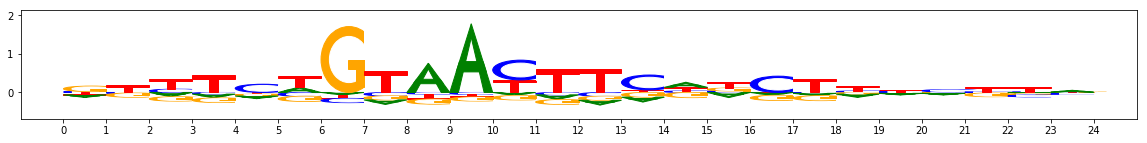

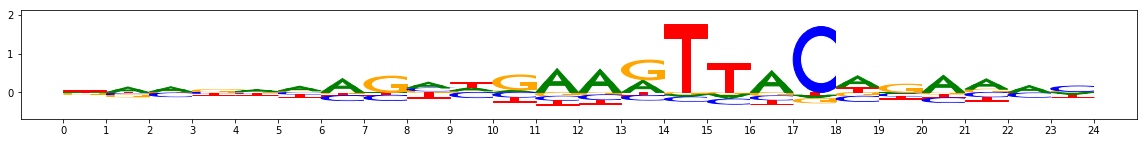

188


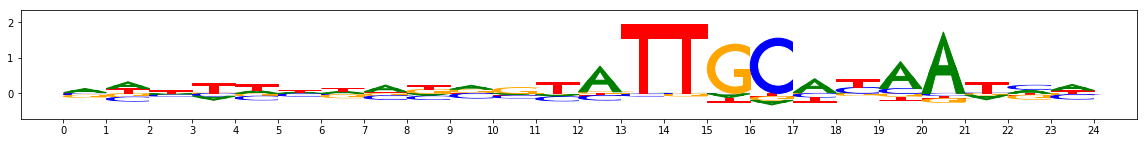

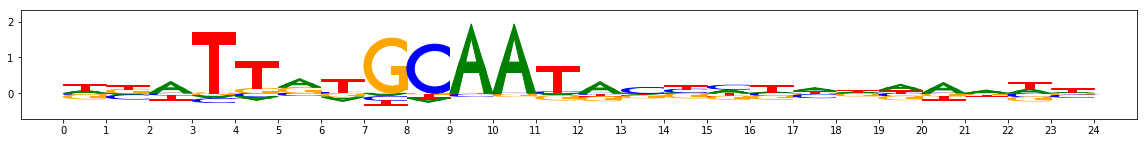

75


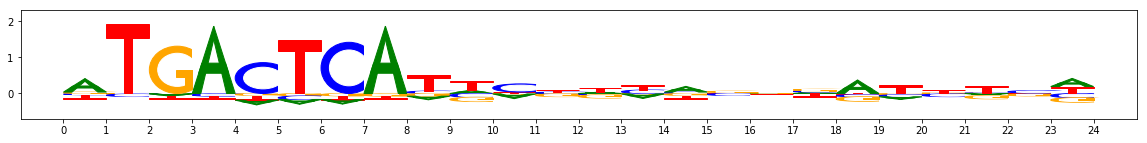

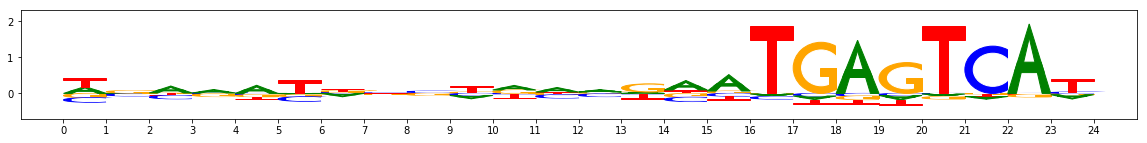

58


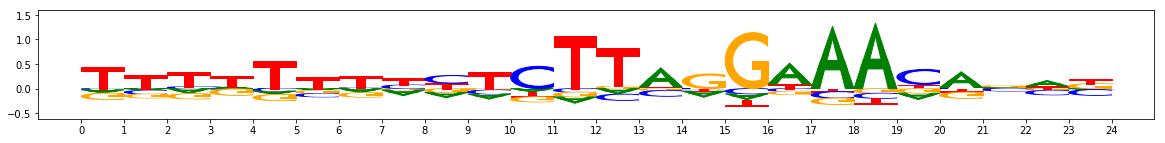

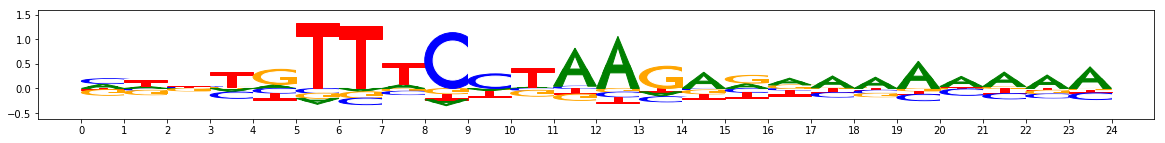

189


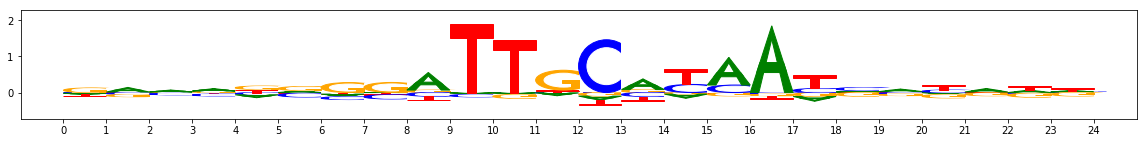

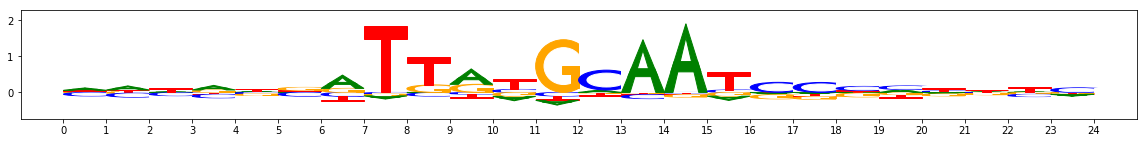

119


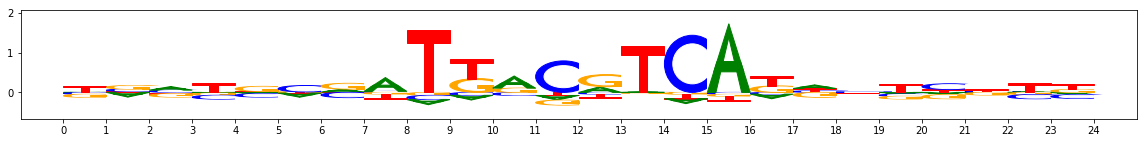

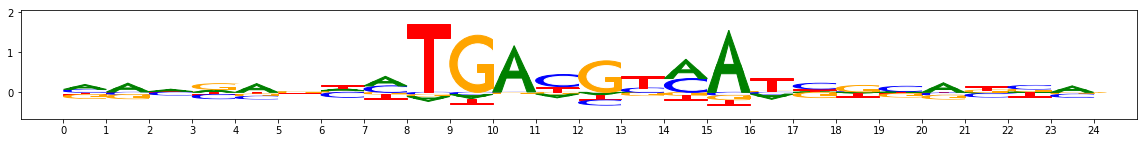

101


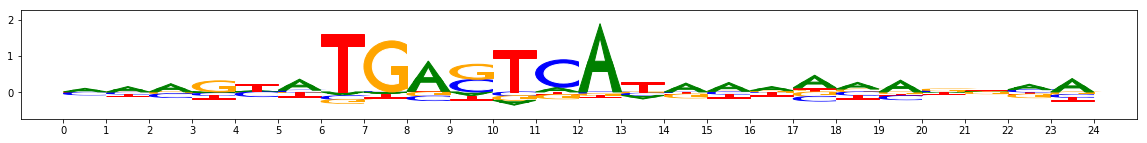

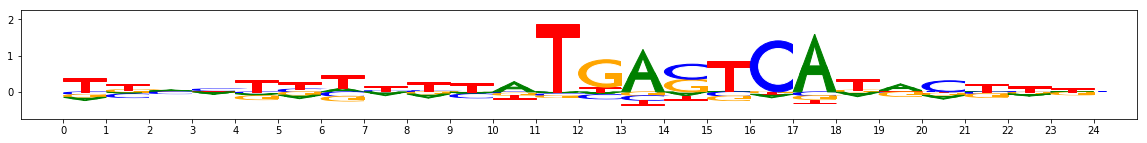

103


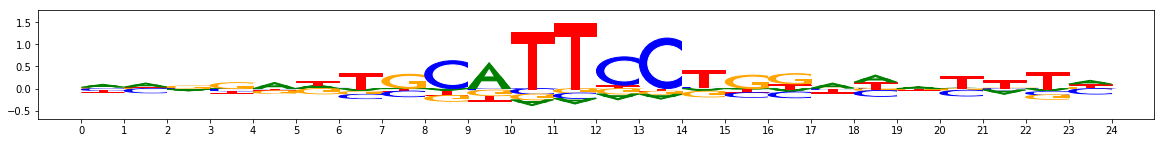

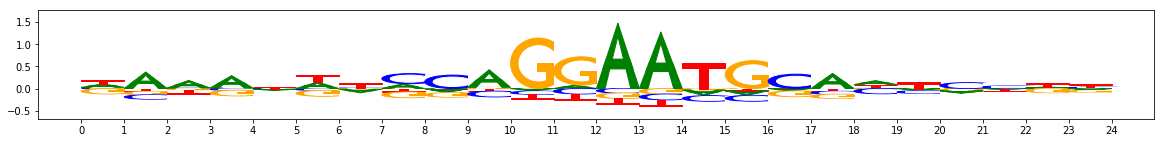

284


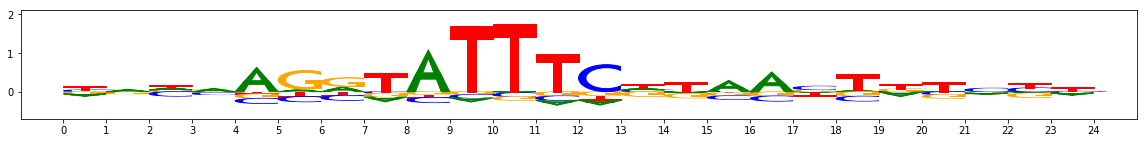

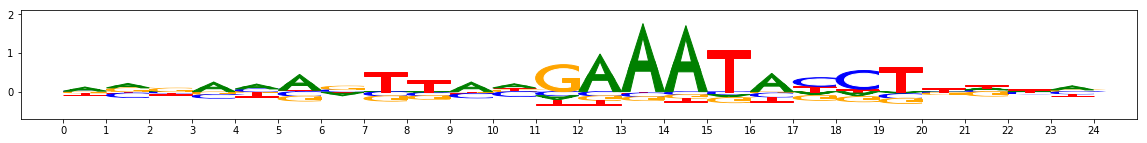

190


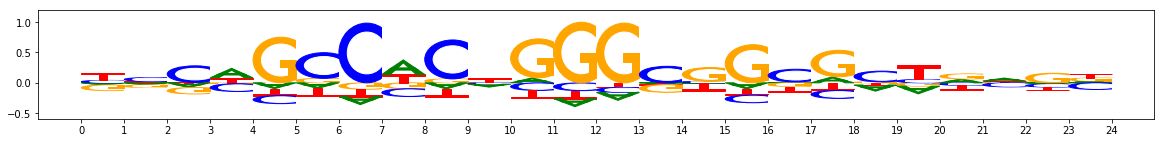

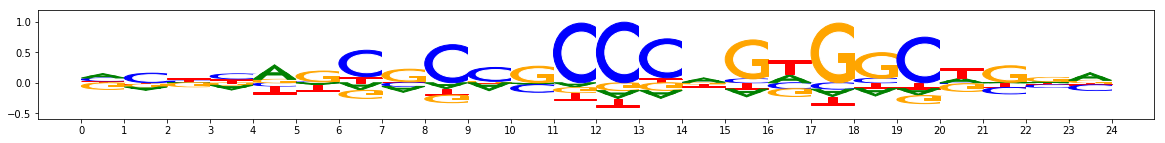

192


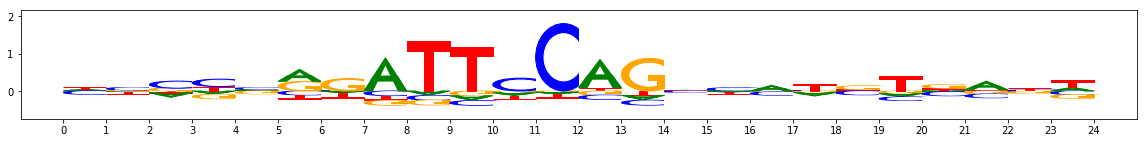

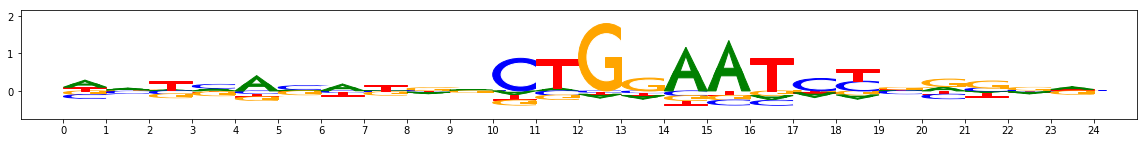

205


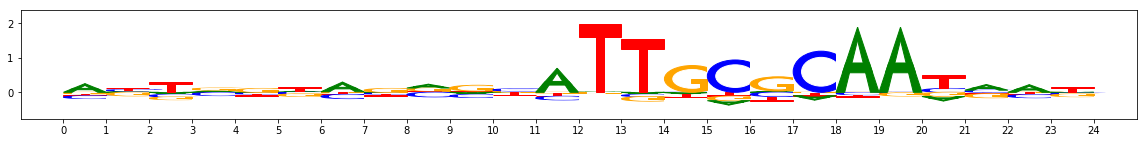

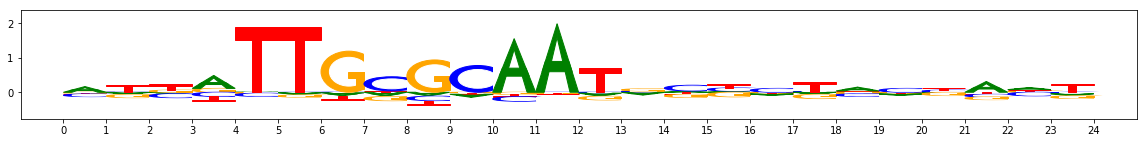

69


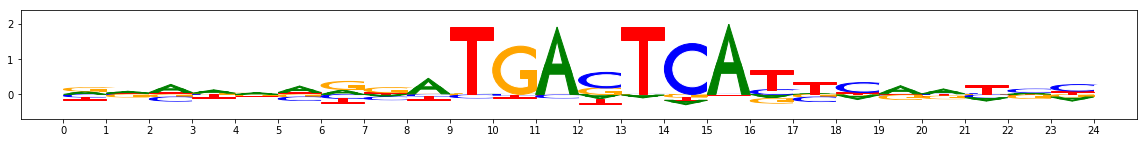

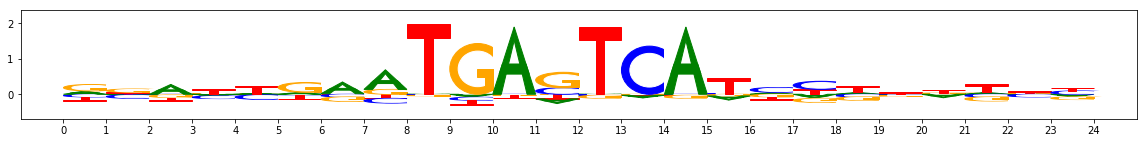

42


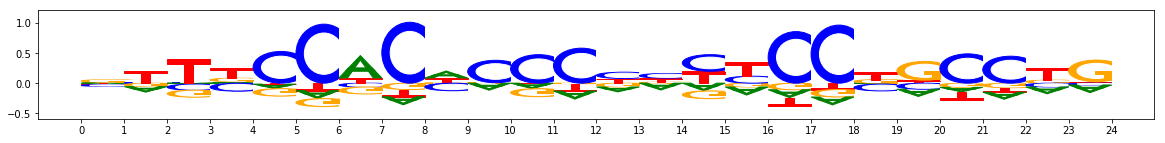

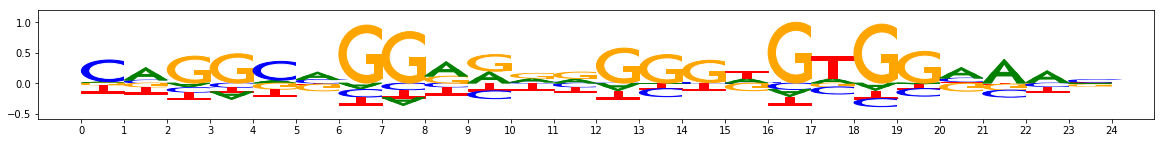

184


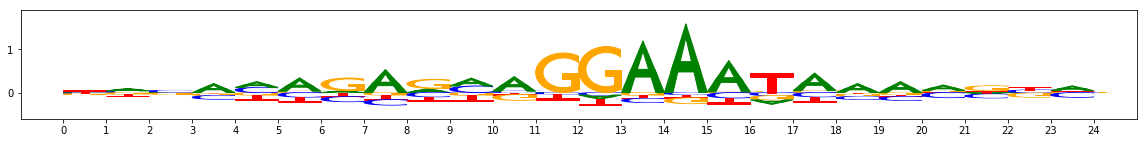

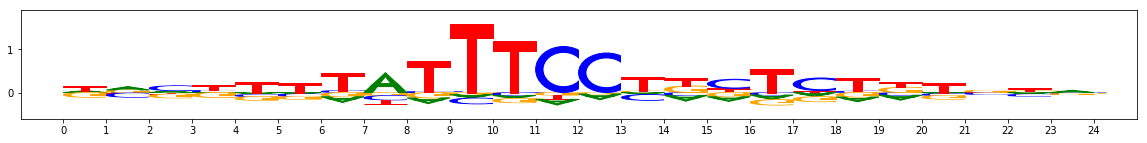

229


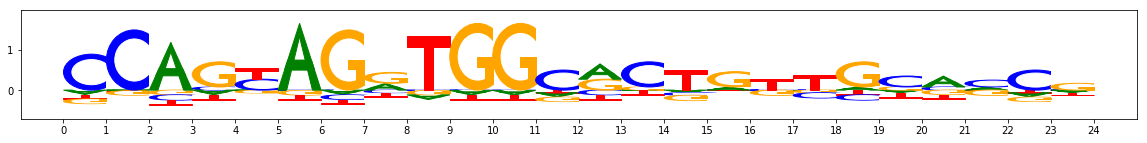

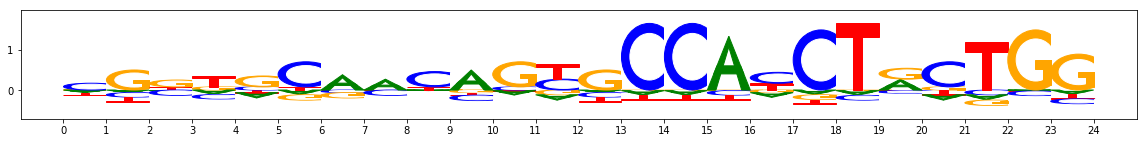

20


In [419]:
for elem in pfm_list_large_300:
    counts_mat,counts=elem[0],elem[1]
    if counts>0:
        pfm=counts_mat/(counts+0.0)
        viz_sequence.plot_weights(get_information_content_matrix(pfm_with_pseudocount(pfm)))
        viz_sequence.plot_weights(get_information_content_matrix(pfm_with_pseudocount(pfm[::-1,::-1])))
        print(counts)

In [398]:
for elem in pfm_list_large_300:
    print elem[1]

188
75
58
189
119
101
103
284
190
192
205
69
42
184
229
20
